<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Collect-cases-script" data-toc-modified-id="Collect-cases-script-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Collect cases script</a></span></li><li><span><a href="#Check-treatment" data-toc-modified-id="Check-treatment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check treatment</a></span></li><li><span><a href="#Check-data" data-toc-modified-id="Check-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check data</a></span></li><li><span><a href="#Test-plotting" data-toc-modified-id="Test-plotting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test plotting</a></span></li></ul></div>

#### Collect cases script

In [30]:
%reload_ext autoreload
%autoreload 2

In [31]:
# import paths
# from scripts import get_raw
# df = get_raw.covid_cases()

#### Check treatment

In [32]:
# from scripts import clean_databases
# dfs = clean_databases.treat_all()
# len(dfs)

In [73]:
import pandas as pd
from paths import *
sorted(TREAT_PATH.glob('*.csv'))

[PosixPath('/mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/SimulaCorona/data/treated/treated_covid19_SUS_database.csv'),
 PosixPath('/mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/SimulaCorona/data/treated/treated_covid19_cases.csv')]

In [109]:
df_sus = pd.read_csv(TREAT_PATH / 'treated_covid19_SUS_database.csv')


### import data

In [93]:
#import sus data
df_sus = pd.read_csv(TREAT_PATH / 'treated_covid19_SUS_database.csv')
cols = ['municipio','populacao' ,'quantidade_leitos']
df_sus = df_sus[cols].fillna(0)

#import cases data
df_cases = pd.read_csv(TREAT_PATH / 'treated_covid19_cases.csv')
df_cases['municipio'] = df_cases['municipio'].fillna('')

#get only last day data for each city
last_date = max(df_cases['date'])
mask = ((df_cases['date']==last_date) & (df_cases['place_type']!='state'))
df_cases = df_cases[mask].sort_values(by='confirmed', ascending=False)

cols = ['municipio','confirmed','deaths','discarded','suspect']
df_cases = df_cases[cols]

#merge sus and cases data
df = pd.merge(df_cases, df_sus, how='left', on='municipio' )

### define parametes

In [220]:
parameters_statics = {
                      'nothing'   :{'R0':8.9,'R_0':3.88},
                      'isolamento':{'R0':4.9,'R_0':1.26},
                      'lockdown'  :{'R0':3.1,'R_0':0.32}
                     }

porcentagem_leitos_ocupados = 80
dias_doente = 15
Percentual_infectados_que_precisam_de_internacao = 8

### run model function

In [244]:
df_final=pd.DataFrame()


for municipio in df['municipio'].unique():
    for case in parameters_statics.keys():
        mask = df['municipio'] == municipio
        df_city = df[mask]
        dd = sir_results(df_city, case,porcentagem_leitos_ocupados,dias_doente,Percentual_infectados_que_precisam_de_internacao)
        df_final = pd.concat([df_final,dd],axis=0)

In [247]:
df_final.to_csv('../data/output/model_for_city.csv', index=False)

In [224]:
def sir_results(df_city,case,porcentagem_leitos_ocupados,dias_doente,Percentual_infectados_que_precisam_de_internacao):
    # Total population, N.
    N = df_city['populacao'].values[0]
    
    # Initial number of infected and recovered individuals, I0 and R0.
    number_of_infected = df_city['confirmed'].values[0]
    percentage_of_immunity = parameters_statics[case]['R0']
    I0, R0 = number_of_infected, number_of_infected * percentage_of_immunity

    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    Numero_de_infectados_por_pessoa_R0 = parameters_statics[case]['R_0']
    R_0 = Numero_de_infectados_por_pessoa_R0

    # Leitos disponíveis
    Total_leitos = df_city['quantidade_leitos'].values[0]
    Leitos_ocupados_outras_doencas = df_city['quantidade_leitos'].values[0] * porcentagem_leitos_ocupados / 100
    leitos = Total_leitos - Leitos_ocupados_outras_doencas


    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0

    gamma = 1. / dias_doente
    beta = R_0 * gamma



    # A grid of time points (in days)
    days = 360
    t = np.linspace(0, days, days)


    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    uti_demand = I * Percentual_infectados_que_precisam_de_internacao / 100


    if max(uti_demand) > leitos == True:
        dday = uti_demand[uti_demand > leitos][0]
        dday = np.where(uti_demand == dday)[0][0]
        plot_dday = 1
    else:
        plot_dday = 0
        dday = -1


    
    dd = pd.DataFrame([municipio]*360,columns=['municipio'])

    dd['populacao'] = N
    dd['porcentagem_leitos_ocupados'] = porcentagem_leitos_ocupados
    dd['dias_doente'] = dias_doente
    dd['percentual_infectados_que_precisam_de_internacao'] = Percentual_infectados_que_precisam_de_internacao
    dd['data_numero_infectados'] = last_date
    dd['numero_infectados'] = number_of_infected
    dd['leitos_total'] = Total_leitos
    dd['leitos_ocupados_outras_doencas'] = Leitos_ocupados_outras_doencas
    dd['leitos_disponiveis'] = leitos
    dd['caso'] = case
    dd['dias'] = t
    dd['demanda_por_uti'] = uti_demand
    dd['dias_para_colapso'] = dday
    dd['suscetiveis'] = S
    dd['infectados'] = I
    dd['recuperados'] = R
    
    
    return(dd)

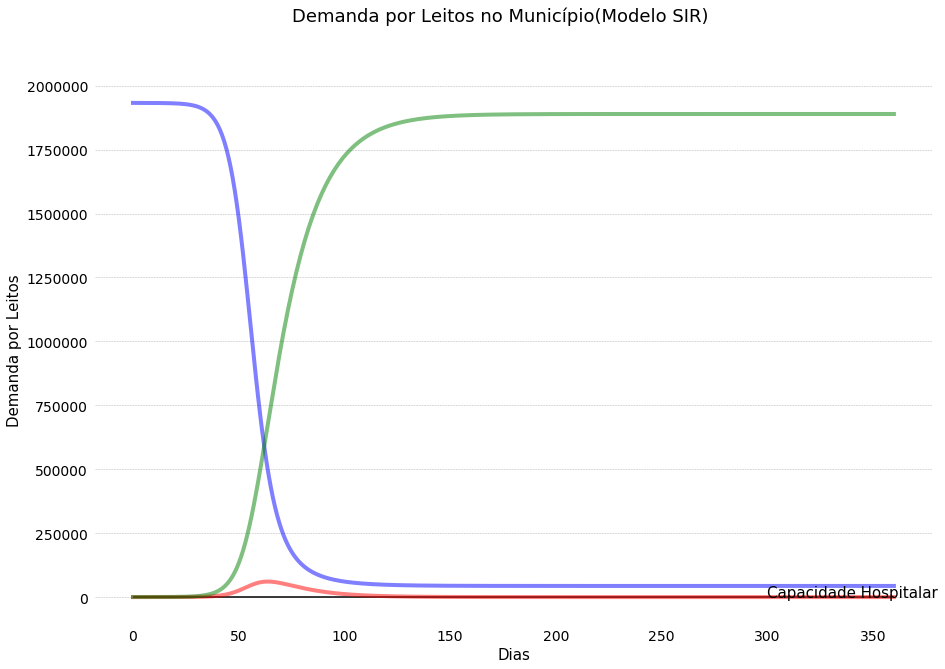

In [201]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
lw = 4
fig = plt.figure(facecolor='w', figsize=(15, 10))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, uti_demand,
            'r', alpha=0.5, lw=lw)

ax.plot(t, S,
            'b', alpha=0.5, lw=lw)

ax.plot(t, R,
            'g', alpha=0.5, lw=lw)



ax.hlines(leitos, 0, days)
ax.text(300, leitos + 50, 
        f'Capacidade Hospitalar', rotation=0, fontdict={"size":15})

if plot_dday==1:
    ax.axvline(dday)
    ax.text(dday-7, max(uti_demand)/3 , f'{dday} dias', rotation=90, fontdict={"size":15})
else:
    pass

ax.tick_params(axis='both', which='both', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)

ax.set_xlabel('Dias', fontdict={"size":15})
ax.set_ylabel('Demanda por Leitos', fontdict={"size":15})

ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.suptitle('Demanda por Leitos no Município(Modelo SIR)', fontsize=18, ha='center')

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## MODELO

- SIR - https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
- https://colab.research.google.com/drive/1bmR-W2NvQ7gPnldTfei927NtGJUCC1BB#scrollTo=47Er1T5YZBXf

    ro - fixo para cada cidade
    populacao de cada cidade


In [119]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md

#@title Variables { run: "auto" }
population_in_million = 220 #@param {type:"number"}
percentage_of_immunity =  1#@param {type:"integer"}
number_of_infected =  125#@param {type:"integer"}
number_of_infected_per_person_R0 =  2.5#@param {type:"number"}
days_to_get_better = 15 #@param {type:"number"}
hospital_capacity_in_thousands = 300#@param {type:"number"}
percentage_of_infected_that_needs_hospital = 5#@param {type:"number"}


In [121]:
# Variables

# Total population, N.
N = population_in_million * 1e6

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = number_of_infected, number_of_infected * percentage_of_immunity

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
R_0 = number_of_infected_per_person_R0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

gamma = 1. / days_to_get_better
beta = R_0 * gamma

hospital_capacity = hospital_capacity_in_thousands * 1e3

# A grid of time points (in days)
days = 360
t = np.linspace(0, days, days)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

uti_demand = I * percentage_of_infected_that_needs_hospital / 100  / 1e3

dday = uti_demand[uti_demand > hospital_capacity_in_thousands][0]
dday = np.where(uti_demand == dday)[0][0]



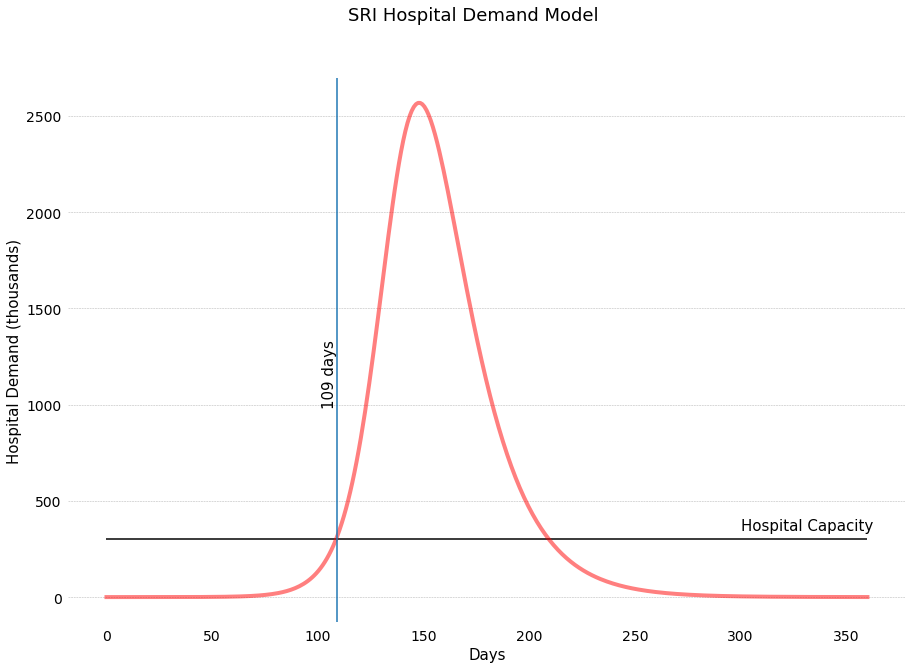

In [28]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
lw = 4
fig = plt.figure(facecolor='w', figsize=(15, 10))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, uti_demand,
            'r', alpha=0.5, lw=lw)

ax.hlines(hospital_capacity_in_thousands, 0, days)
ax.text(300, hospital_capacity_in_thousands + 50, 
        f'Hospital Capacity', rotation=0, fontdict={"size":15})
ax.axvline(dday)
ax.text(dday-7, 1e3 , f'{dday} days', rotation=90, fontdict={"size":15})


ax.tick_params(axis='both', which='both', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)

ax.set_xlabel('Days', fontdict={"size":15})
ax.set_ylabel('Hospital Demand (thousands)', fontdict={"size":15})

ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.suptitle('SRI Hospital Demand Model', fontsize=18, ha='center')

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()